# Setup Environment 

In [1]:
# pip install opencv-python

In [2]:
# pip install matplotlib

In [3]:
# pip install tensorflow

In [4]:
# pip install scipy

In [5]:
# pip install scikit-learn

# Import Library

In [6]:
import os
import cv2
import random
import shutil
import string
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing

### Filtering

In [7]:
class ImageProcessor:
    def __init__(self, dataset_path, output_img_filter, threshold):
        self.dataset_path = dataset_path
        self.output_img_filter = output_img_filter
        self.threshold = threshold

    def laplacian_of_gaussian(self, image):
        # Gaussian Blur
        image_blurred = cv2.GaussianBlur(image, (15, 15), 0)

        # Laplacian of Gaussian (LoG) Operator
        edges_log = cv2.Laplacian(image_blurred, cv2.CV_64F, ksize=3)

        # Thresholding untuk hasil deteksi tepi
        detected_edges_log = np.zeros_like(edges_log, dtype=np.uint8)
        detected_edges_log[edges_log > self.threshold] = 255

        return detected_edges_log

    def process_images(self):
        # Buat folder untuk menyimpan hasil filter jika belum ada
        if not os.path.exists(self.output_img_filter):
            os.makedirs(self.output_img_filter)

        # Iterasi melalui setiap subfolder
        for folder_name in os.listdir(self.dataset_path):
            folder_path = os.path.join(self.dataset_path, folder_name)

            # Pastikan yang diakses adalah subfolder
            if os.path.isdir(folder_path):
                # print(f"Processing images in folder: {folder_name}")

                # Membuat subfolder dalam folder output dengan nama yang sama dengan subfolder di dataset
                output_folder_path = os.path.join(self.output_img_filter, folder_name)
                if not os.path.exists(output_folder_path):
                    os.makedirs(output_folder_path)

                # Iterasi melalui setiap gambar dalam subfolder
                for image_name in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, image_name)

                    # Memeriksa apakah file yang diakses adalah file gambar
                    if image_name.endswith(('.png', '.jpg', '.jpeg')):
                        # Membaca gambar
                        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                        # Memanggil fungsi Laplacian of Gaussian Operator
                        result = self.laplacian_of_gaussian(image)

                        # Menyimpan hasil filter ke folder output
                        output_image_path = os.path.join(output_folder_path, image_name)
                        cv2.imwrite(output_image_path, result)

        print("Filtering completed and filtered images saved !")

# Inisialisasi objek ImageProcessor dan panggil metode process_images
dataset_path = "../data/data_original/javaneseScript_byPhiard/train"
output_img_filter = "../data/data_preprocessing/v0.4/filtered/"
threshold = 5

processor = ImageProcessor(dataset_path, output_img_filter, threshold)
processor.process_images()

Filtering completed and filtered images saved !


### Augmented Data

In [8]:

class ImageAugmentor:
    def __init__(self, dataset_dir, output_img_aug):
        self.dataset_dir = dataset_dir
        self.output_img_aug = output_img_aug

    def augment_images(self):
        datagen = ImageDataGenerator(
            rotation_range=19,
            shear_range=0.1,
            zoom_range=0.1,
            fill_mode='nearest'
        )

        # Membuat folder baru untuk menyimpan hasil augmentasi
        if not os.path.exists(self.output_img_aug):
            os.makedirs(self.output_img_aug)

        # Loop melalui setiap kelas dalam dataset
        for class_name in os.listdir(self.dataset_dir):
            class_path = os.path.join(self.dataset_dir, class_name)

            # Membuat folder baru untuk setiap kelas di dalam folder output
            output_class_path = os.path.join(self.output_img_aug, class_name)
            if not os.path.exists(output_class_path):
                os.makedirs(output_class_path)

            # Mendapatkan list file gambar di setiap kelas
            image_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if
                           file.endswith(('jpg', 'jpeg', 'png'))]

            # Loop melalui setiap file gambar dan augmentasi datanya
            for img_path in image_files:
                # img = image.load_img(img_path, target_size=(64, 64), color_mode='grayscale')
                img = image.load_img(img_path, target_size=(64, 64))
                x = image.img_to_array(img)
                x = x.reshape((1,) + x.shape)

                # Proses augmented images
                i = 0
                for batch in datagen.flow(x, batch_size=32, save_to_dir=output_class_path,
                                          save_prefix=os.path.splitext(os.path.basename(img_path))[0] + '_aug',
                                          save_format='png'):
                    i += 1
                    if i >= 655:
                        break
                break

        print(f"Image Augmentation Complete!")

# Contoh penggunaan:
dataset_dir = output_img_filter
output_img_aug = "../data/data_preprocessing/v0.4/augmented/"

augmentor = ImageAugmentor(dataset_dir, output_img_aug)
augmentor.augment_images()

Image Augmentation Complete!


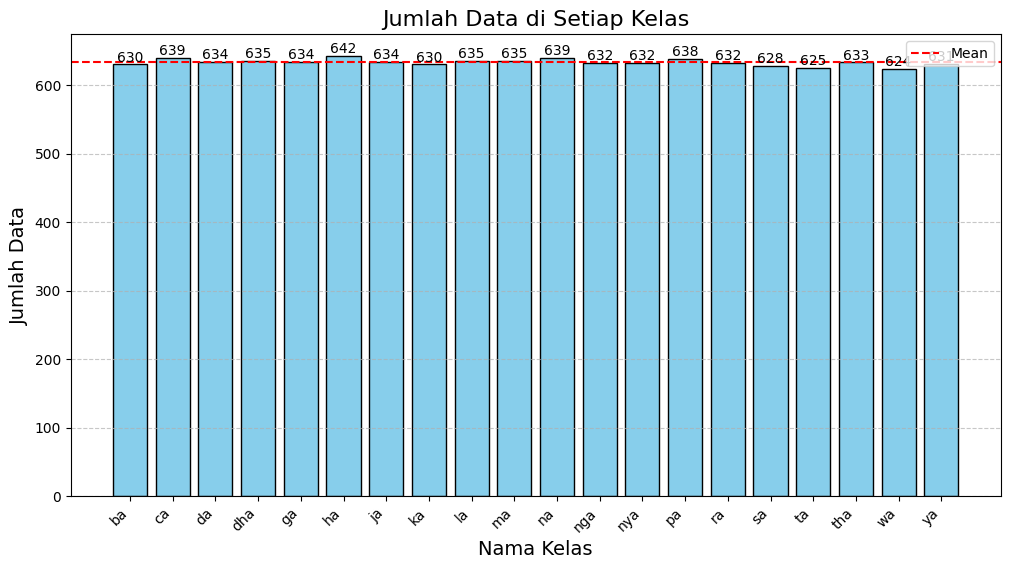

In [9]:
# Inisialisasi dictionary untuk menyimpan jumlah setiap kelas
counter_kelas = {}

# Menghitung jumlah setiap kelas
for kelas_folder in os.listdir(output_img_aug):
    kelas_folder_path = os.path.join(output_img_aug, kelas_folder) 
    
    # Memastikan bahwa yang sedang diiterasi adalah direktori (bukan file)
    if os.path.isdir(kelas_folder_path):
        # Inisialisasi hitungan untuk kelas tertentu
        kelas_counter = 0
        
        # Menghitung jumlah file PNG di dalam subfolder
        for file in os.listdir(kelas_folder_path):
            if file.lower().endswith('.png'):
                kelas_counter += 1
        
        # Menyimpan jumlah file PNG untuk kelas tertentu
        counter_kelas[kelas_folder] = kelas_counter
        
# Memisahkan nama kelas dan jumlah
kelas = list(counter_kelas.keys())
jumlah = list(counter_kelas.values())

# Membuat diagram batang dengan label dan warna yang berbeda
fig, ax = plt.subplots(figsize=(12, 6))  # Mengatur ukuran figur
bars = ax.bar(kelas, jumlah, color='skyblue', edgecolor='black')  # Menyesuaikan warna batang

# Menambahkan label dan judul
plt.xlabel('Nama Kelas', fontsize=14)  # Menyesuaikan ukuran font dan label sumbu x
plt.ylabel('Jumlah Data', fontsize=14)  # Menyesuaikan ukuran font dan label sumbu y
plt.title('Jumlah Data di Setiap Kelas', fontsize=16)  # Menyesuaikan ukuran font judul

# Menambahkan label pada setiap batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')  # Menyesuaikan ukuran font dan warna teks

# Menyesuaikan tampilan sumbu x
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotasi label sumbu x, penempatan horizontal, dan ukuran font

# Menyesuaikan tampilan sumbu y
plt.yticks(fontsize=10)  # Menyesuaikan ukuran font sumbu y

# Menambahkan grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan garis horizontal pada mean atau median (opsional)
plt.axhline(y=np.mean(jumlah), color='red', linestyle='--', label='Mean')  # Atau ganti dengan np.median(jumlah) untuk median
plt.legend()

# Menampilkan diagram batang
plt.show()

### Imbalanced Dataset

In [13]:
# Path dataset
data = output_img_aug

# List kelas
kelas_aksara = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

# Target jumlah gambar per kelas
target_jumlah = 642

# Loop untuk setiap kelas
for kelas in kelas_aksara:
    # Path kelas
    kelas_path = os.path.join(data, kelas)
    
    # Jumlah gambar saat ini
    jumlah_gambar = len(os.listdir(kelas_path))
    
    # Selisih gambar yang perlu ditambahkan
    selisih = target_jumlah - jumlah_gambar
    
    # Jika selisih positif, lakukan oversampling
    if selisih > 0:
        # Ambil sampel acak dari gambar yang sudah ada
        gambar_oversampling = random.sample(os.listdir(kelas_path), selisih)
        
        # Copy gambar oversampling ke dalam kelas
        for gambar in gambar_oversampling:
            source_path = os.path.join(kelas_path, gambar)
            
            # Generate sufiks acak
            sufiks_acak = ''.join(random.choices(string.ascii_letters + string.digits, k=8))
            
            # Tentukan path tujuan dengan menambahkan sufiks acak
            target_path = os.path.join(kelas_path, f'{os.path.splitext(gambar)[0]}_{sufiks_acak}{os.path.splitext(gambar)[1]}')
            
            # Salin gambar ke target path
            shutil.copy(source_path, target_path)

# Cetak ulang jumlah gambar per kelas setelah penyamaan
for kelas in kelas_aksara:
    kelas_path = os.path.join(data, kelas)
    jumlah_gambar = len(os.listdir(kelas_path))
    print(f'Aksara {kelas} jumlah: {jumlah_gambar}')

Aksara ba jumlah: 642
Aksara ca jumlah: 642
Aksara da jumlah: 642
Aksara dha jumlah: 642
Aksara ga jumlah: 642
Aksara ha jumlah: 642
Aksara ja jumlah: 642
Aksara ka jumlah: 642
Aksara la jumlah: 642
Aksara ma jumlah: 642
Aksara na jumlah: 642
Aksara nga jumlah: 642
Aksara nya jumlah: 642
Aksara pa jumlah: 642
Aksara ra jumlah: 642
Aksara sa jumlah: 642
Aksara ta jumlah: 642
Aksara tha jumlah: 642
Aksara wa jumlah: 642
Aksara ya jumlah: 642


### Split Dataset

In [14]:
# Path ke direktori utama yang berisi sub-direktori untuk masing-masing kelas
main_data_dir = output_img_aug

# Path ke direktori output untuk train dan test set
path_dir = '../data/data_preprocessing/v0.4/data_split'

# Membuat sub-direktori train dan test
train_dir = os.path.join(path_dir, 'train')
test_dir = os.path.join(path_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop melalui masing-masing kelas (diasumsikan ada 20 kelas)
for class_name in os.listdir(main_data_dir):
    class_path = os.path.join(main_data_dir, class_name)
    
    # Mendapatkan list file untuk kelas tertentu
    files = os.listdir(class_path)
    
    # Membagi data menjadi train dan test set
    train_files, test_files = train_test_split(files, test_size=0.3, random_state=35)
    
    # Membuat sub-direktori untuk masing-masing kelas di train dan test set
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Menyalin file ke dalam masing-masing sub-direktori
    for file in train_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(train_class_dir, file))
    
    for file in test_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(test_class_dir, file))

print("Data Splitting Completed !")

Data Splitting Completed !


### Convert Image to Grayscale

In [12]:
# # Fungsi untuk konversi gambar RGB ke grayscale
# def rgb_to_gray(input_path, output_path):
#     # Baca gambar
#     image = cv2.imread(input_path)
#     # Konversi ke grayscale
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     # Simpan gambar grayscale
#     cv2.imwrite(output_path, gray_image)

# # Fungsi untuk melakukan konversi pada semua gambar dalam folder
# def convert_images_in_folder(folder_path, output_folder_path):
#     # Loop melalui semua file dalam folder
#     for filename in os.listdir(folder_path):
#         # Buat path lengkap ke file
#         file_path = os.path.join(folder_path, filename)
#         # Jika file adalah file gambar
#         if os.path.isfile(file_path) and any(file_path.endswith(extension) for extension in ['.jpg', '.png', '.jpeg']):
#             # Buat nama file untuk gambar grayscale
#             output_path = os.path.join(output_folder_path, filename)
#             # Konversi gambar RGB ke grayscale
#             rgb_to_gray(file_path, output_path)

# # Fungsi untuk melakukan konversi pada semua gambar dalam 20 subfolder
# def convert_images_in_subfolders(main_folder_path, output_img_convert):
#     # Loop melalui semua subfolder
#     for subdir_name in os.listdir(main_folder_path):
#         subdir_path = os.path.join(main_folder_path, subdir_name)
#         # Jika itu adalah subfolder
#         if os.path.isdir(subdir_path):
#             # print(f"Image convert in class: {subdir_name}")
#             # Buat subfolder baru di dalam folder output
#             output_subfolder_path = os.path.join(output_img_convert, subdir_name)
#             os.makedirs(output_subfolder_path, exist_ok=True)
#             # Lakukan konversi pada semua gambar dalam subfolder dan simpan dalam folder baru
#             convert_images_in_folder(subdir_path, output_subfolder_path)
    
#     print("Image conversion completed !")

# # Path ke folder utama yang berisi 20 subfolder
# main_folder_path = "../data/data_original/javaneseScript_byPhiard/train"
# output_img_convert = "../data/data_preprocessing/v0.4/grayscale"
# # output_img_convert = "../data/data_preprocessing/v0.5/grayscale"

# # Panggil fungsi untuk melakukan konversi pada semua gambar dalam 20 subfolder
# convert_images_in_subfolders(main_folder_path, output_img_convert)